In [7]:
%matplotlib inline

In [8]:
import matplotlib.pyplot as plt
import numpy as np
plt.rc('font', size=20)
from thunder.extraction.extraction import SourceExtraction
from thunder.extraction.block.mergers import OverlapBlockMerger
from thunder.extraction.demixers import Demixer
from thunder.rdds.images import Images
from thunder.rdds.timeseries import TimeSeries
from scipy.ndimage.filters import gaussian_filter
from scipy.io import loadmat

# Fetch data

In [9]:
data_source = 3

# Fetch Data
if data_source == 1:  # generate 2D model data
    np.random.seed(1)
    T = 30  # duration of the simulation
    sz = (150, 100)  # size of image
    sig = (5, 5)  # neurons size
    foo = 0.1 * np.random.randn(*((T,) + sz))
    bar = np.zeros((T,) + sz)
    N = 15  # number of neurons
    lam = 1
    for i in range(N):
        ind = tuple([np.random.randint(x) for x in sz])
        for j in range(T):
            bar[(j,) + ind] = abs(np.random.randn())
    data = foo + 10 * gaussian_filter(bar, (0,) + sig)
    TargetArea = N * np.prod(2. * np.array(sig)) / np.prod(sz)
    TargetRange = [TargetArea * 0.7, TargetArea * 1.]
    NonNegative = True
    lam = 1
elif data_source == 2:   # Use experimental 2D data
    mat = loadmat('Datasets/data_exp2D')
    data = np.transpose(mat['data'], [2, 0, 1])
    sig = (6, 6)  # estimated neurons size
    N = 40  # estimated number of neurons
    TargetArea = N * np.prod(2. * np.array(sig)) / np.prod(data[0].shape)
    TargetRange = [TargetArea * 0.8, TargetArea * 1.2]
    NonNegative = True
    lam = 1
elif data_source == 3:   # Use experimental 3D data
    mat = loadmat('Datasets/data_exp3D')
    data = np.transpose(mat['data'], [3, 0, 1, 2])
    sig = (2, 2, 2)  # neurons size
    TargetRange = [0.005, 0.015]
    NonNegative = True
    lam = 0.01

In [10]:
dataimg=Images(sc.parallelize(zip(range(len(data)), data)))
blocks0 = dataimg.toBlocks() #(50,50), padding=30)
blocks0.count()

1

# Run source detection algorithms; Plot results

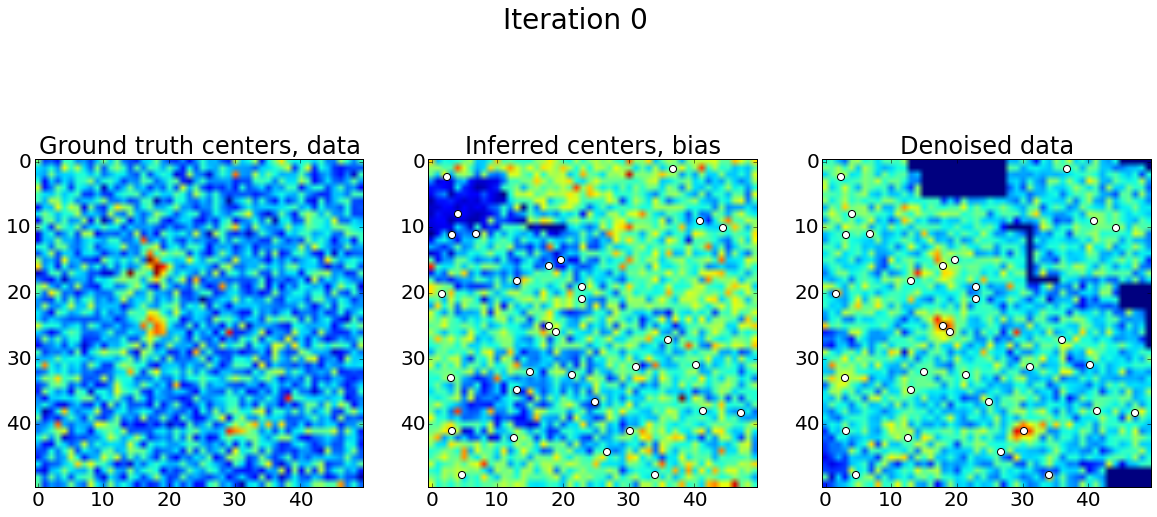

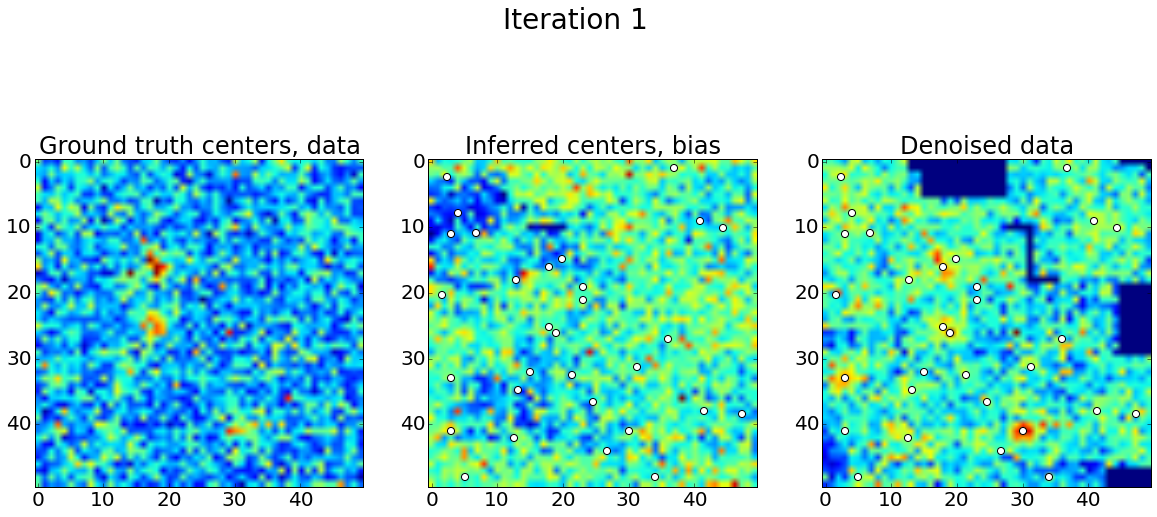

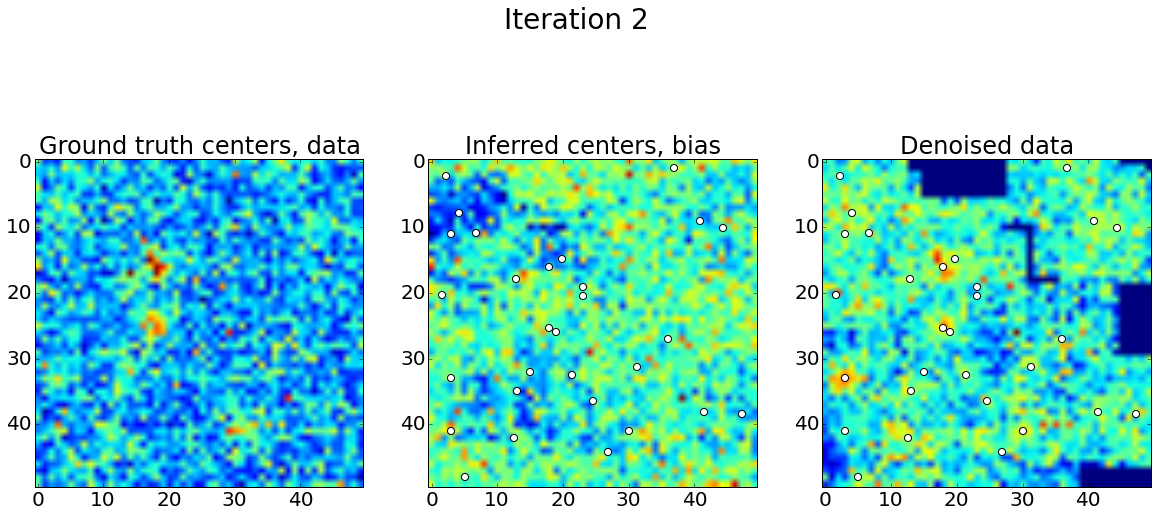

In [11]:
# blocks0 is original data
# blocks original data-background
blocks = blocks0
pic_data = np.percentile(data, 90, axis=0)
for iteration in range(3):
    # run GroupLasso and LocalNMF
    if blocks.count()==1:
        sources = SourceExtraction('grouplasso', sig=sig, nonNegative=True, verbose=True, 
                    targetAreaRatio=TargetRange, lam=lam).fit(blocks)
    else:
        sources = SourceExtraction('grouplasso', merger=OverlapBlockMerger(.25), 
                    sig=sig, nonNegative=True, verbose=True, 
                    targetAreaRatio=map(lambda x:x/3.5, TargetRange), lam=lam).fit(blocks)
    modelB = Demixer(sig=sig, verbose=True).fit(blocks, sources, 'blocks')
    model = modelB.map(lambda x: x[1])
    model = TimeSeries(model.flatMap(lambda x: zip(x[0], x[1])))
    blocks = Demixer(sig=sig, verbose=True).subtractBackground(blocks0, modelB)
    # get denoised pic
    denoised_data = 0 * data
    ks, vs = model.collectAsArray()
    for ll, k in enumerate(ks):
        for i, c in enumerate(k.coordinates):
            denoised_data[(slice(0,None),)+tuple(c)] = k.values[i]*vs[ll]
    pic_denoised = np.percentile(denoised_data, 90, axis=0)
    # plot
    if blocks.count()==1:
        pic_bias = np.percentile(data-blocks.collectValuesAsArray()[0], 90, 0)
    else:
        pic_bias = np.percentile(data-blocks.toImages().collectValuesAsArray(), 90, 0)    
    plt.figure(figsize=(20,9))
    plt.suptitle('Iteration '+str(iteration), fontsize=28, y=1)
    plt.subplot(131)
    if data_source==1:
        plt.scatter(*np.where(bar.max(0)>0)[1::-1], s=50,  marker='o', c='white');
    plt.hold(True)
    plt.imshow(pic_data if data_source != 3 else pic_data.max(-1));
    plt.title('Ground truth centers, data')
    plt.subplot(132)
    plt.scatter(*sources.centers.T[1::-1], s=50,  marker='o', c='white');
    plt.imshow(pic_bias if data_source != 3 else pic_bias.max(-1));
    plt.title('Inferred centers, bias')
    plt.subplot(133)
    plt.scatter(*sources.centers.T[1::-1], s=50,  marker='o', c='white');
    plt.imshow(pic_denoised if data_source != 3 else pic_denoised.max(-1));
    plt.title('Denoised data');
    plt.show()

# Video results 

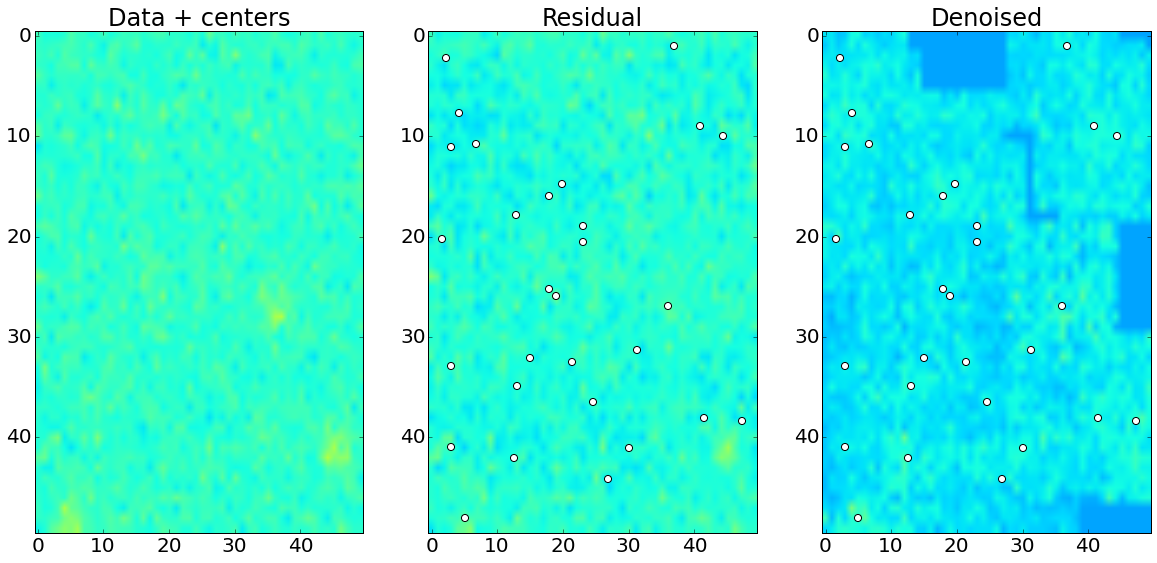

In [14]:
residual = data - denoised_data 
from IPython.core.display import clear_output
mi = np.min(data)
ma = np.max(data)
for ii in range(data.shape[0]):
    ax = plt.subplot(131)
    plt.gcf().set_size_inches(20,9)
    if data_source==1:
        ax.scatter(*np.where(bar.max(0)>0)[1::-1], s=50, marker='o', c='white')
#     plt.hold(True)
    ax.imshow(data[ii] if data_source != 3 else data[ii].max(-1),
              vmin=mi, vmax=ma, aspect='auto')
    ax.set_title('Data + centers')
    ax2 = plt.subplot(132)
    ax2.scatter(*sources.centers.T[1::-1], s=50, marker='o', c='white')
    ax2.imshow(residual[ii] if data_source != 3 else residual[
               ii].max(-1), vmin=mi, vmax=ma, aspect='auto')
    ax2.set_title('Residual')
    ax3 = plt.subplot(133)
    ax3.scatter(*sources.centers.T[1::-1], s=50, marker='o', c='white')
    ax3.imshow(denoised_data[ii] if data_source != 3 else denoised_data[
               ii].max(-1), vmin=mi, vmax=ma, aspect='auto')
    ax3.set_title('Denoised')
    plt.savefig('tmp/'+str(ii)+'.png')
    clear_output(True)
    plt.show()

In [13]:
plt.savefig?
